In [1]:
import re
import pickle
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

from utils import camelcase_to_underscore


sns.set(style="white", palette="muted", color_codes=True)

### Read Data

In [2]:
# Full
# df = pd.read_csv('input/train_V2.csv')
# Sample
df = pd.read_csv('input/train_V2.csv', nrows=10000)
df.columns = [camelcase_to_underscore(col) for col in df.columns]
display(df.head(), df.shape, list(df.columns))

,id,group_id,match_id,assists,boosts,damage_dealt,dbn_os,headshot_kills,heals,kill_place,...,revives,ride_distance,road_kills,swim_distance,team_kills,vehicle_destroys,walk_distance,weapons_acquired,win_points,win_place_perc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


(10000, 29)

['id',
 'group_id',
 'match_id',
 'assists',
 'boosts',
 'damage_dealt',
 'dbn_os',
 'headshot_kills',
 'heals',
 'kill_place',
 'kill_points',
 'kills',
 'kill_streaks',
 'longest_kill',
 'match_duration',
 'match_type',
 'max_place',
 'num_groups',
 'rank_points',
 'revives',
 'ride_distance',
 'road_kills',
 'swim_distance',
 'team_kills',
 'vehicle_destroys',
 'walk_distance',
 'weapons_acquired',
 'win_points',
 'win_place_perc']

### Drop NaN Target observations

In [3]:
df.drop(df[df['win_place_perc'].isnull()].index, inplace=True)

### Select Numerical Features

In [4]:
id_features = ['id', 'group_id', 'match_id']
categorical_features = ['match_type', ]
target_feature = 'win_place_perc'
base_features = [col for col in df.columns if col not in id_features + categorical_features + [target_feature]] 

### Count Unique Values

In [5]:
df['group_id'].nunique(), df['match_id'].nunique(), df['match_type'].nunique()

(9971, 9059, 15)

### Explore Target

count    10000.000000
mean         0.472508
std          0.307031
min          0.000000
25%          0.200000
50%          0.458300
75%          0.740700
max          1.000000
Name: win_place_perc, dtype: float64

/Users/dmitrymikhailovich_/cnt/pubg-kaggle/.direnv/python-3.6.3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


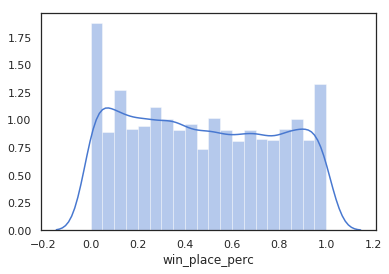

In [6]:
display(df[target_feature].describe())
sns.distplot(df[target_feature])
plt.show()

In [7]:
# from features import GroupAggregatedFeatureGenerator, SimpleFeatureGenerator

# simple_feature_generator = SimpleFeatureGenerator()
# df_features = pd.concat([df, simple_feature_generator.fit_transform(df)], axis=1)

# features = base_features + simple_feature_generator.get_feature_names()
# df_features = pd.concat([df_features, GroupAggregatedFeatureGenerator(features).fit_transform(df_features)], axis=1)

In [8]:
# from sklearn.linear_model import Ridge

In [9]:
from features import FeatureGenerator

feature_generator = FeatureGenerator(
    id_columns=id_features, 
    numerical_columns=base_features, 
    categorical_columns=categorical_features,
    target_column=target_feature,
)
df_features = feature_generator.fit_transform(df)

In [10]:
from preprocessing import Preprocessor

preprocessor = Preprocessor(
    id_columns=id_features, 
    numerical_columns=base_features,
    categorical_columns=categorical_features,
    target_column=target_feature,
)
x = preprocessor.fit_transform(df_features)

In [13]:
from pipelines import Pipeline

pipeline = Pipeline(
    id_columns=id_features, 
    numerical_columns=base_features,
    categorical_columns=categorical_features,
    target_column=target_feature,
)
x = pipeline.fit_transform(df)

In [14]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 2)
kfold.get_n_splits(x)

2

In [21]:
from pipelines import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

log = []
for train_index, valid_index in kfold.split(df):
    step = dict()
    pipeline = Pipeline(
        id_columns=id_features, 
        numerical_columns=base_features,
        categorical_columns=categorical_features,
        target_column=target_feature,
    )
    x_train = pipeline.fit_transform(df.loc[train_index, :])
    y_train = df.loc[train_index, target_feature]
    x_valid = pipeline.transform(df.loc[valid_index, :])
    y_valid = df.loc[valid_index, target_feature]
    
#     model = Ridge(alpha=1)
    model = RandomForestRegressor(
        n_jobs=-1, 
        n_estimators=10, 
        criterion='mae', 
        max_depth=5,
    )
    model.fit(x_train, y_train)
    step['train_score'] = mean_absolute_error(y_train, model.predict(x_train))
    step['valid_score'] = mean_absolute_error(y_valid, model.predict(x_valid))
    print(step)
    log.append(step)

{'train_score': 0.08029392399999999, 'valid_score': 0.091569395}
{'train_score': 0.07907778, 'valid_score': 0.08701266700000002}


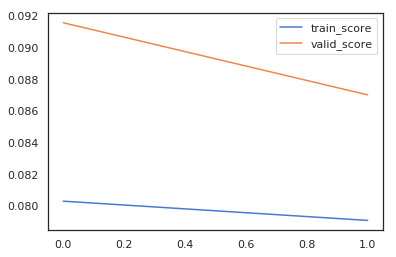

In [23]:
df_scores = pd.DataFrame(log)
df_scores.plot()
plt.show()